## Model Evaluation
Section 5.1 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/hyunsung/Workspace/soccercpd'

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from src.myconstants import *

sns.set(font='Arial', font_scale=1.5)

### Loading the human-annoatated formation data

Formation and change-point labels annotated by domain experts

In [3]:
role_tags_true = pd.read_csv('data/role_tags_true.csv', header=0)
role_tags_true

,activity_id,role_period,session,start_time,end_time,formation,squad_num,aligned_role
0,2310,1,1,0,36,4231,1,GK
1,2310,1,1,0,36,4231,4,RCB
2,2310,1,1,0,36,4231,7,LM
3,2310,1,1,0,36,4231,14,CAM
4,2310,1,1,0,36,4231,18,CF
...,...,...,...,...,...,...,...,...
1713,21704,7,2,11,50,442,51,GK
1714,21704,7,2,11,50,442,62,RCM
1715,21704,7,2,11,50,442,9,RCF
1716,21704,7,2,11,50,442,17,RB


In [4]:
form_tags_true = role_tags_true[role_tags_true.columns[:-2]].drop_duplicates().reset_index(drop=True)
form_tags_true

,activity_id,role_period,session,start_time,end_time,formation
0,2310,1,1,0,36,4231
1,2310,2,1,36,46,4231
2,2310,3,2,0,22,4231
3,2310,4,2,22,42,4231
4,2310,5,2,42,51,433
...,...,...,...,...,...,...
151,21704,3,1,24,31,4231
152,21704,4,1,31,47,4231
153,21704,5,2,0,5,442
154,21704,6,2,5,11,442


### Formatting the predicted formation data
Format the formation and role labels predicted by SoccerCPD for comparison with the human-annotated labels.

In [5]:
role_periods = pd.read_csv('data/role_periods.csv', header=0)
form_periods = pd.read_pickle('data/form_periods.pkl')
form_tags_pred = pd.merge(role_periods, form_periods[['activity_id', 'form_period', 'formation']])

activity_ids = form_tags_true['activity_id'].unique()
form_tags_pred = form_tags_pred[form_tags_pred['activity_id'].isin(activity_ids)].reset_index(drop=True)
form_tags_pred

,activity_id,player_period,form_period,role_period,session,start_time,end_time,formation
0,2310,1,1,1,1,0,35,442
1,2310,1,1,2,1,35,46,442
2,2310,2,2,3,2,0,22,343
3,2310,3,2,4,2,22,42,343
4,2310,4,2,5,2,42,51,343
...,...,...,...,...,...,...,...,...
147,21704,1,1,3,1,23,31,4231
148,21704,1,1,4,1,31,47,4231
149,21704,2,2,5,2,0,6,442
150,21704,2,2,6,2,6,11,442


In [6]:
form_tags_true.to_csv('data/form_tags_true.csv', index=False)
form_tags_pred.to_csv('data/form_tags_pred.csv', index=False)

#### (1) Formation prediction accuracy

In [7]:
mins_header = ['activity_id', 'session', 'start_time', 'formation']

mins_pred = []
for i in form_tags_pred.index:
    period_pred = form_tags_pred.iloc[i]
    start_time = period_pred['start_time']
    end_time = period_pred['end_time']
    duration = end_time - start_time
    period_mins_pred = pd.DataFrame(
        np.repeat(period_pred[mins_header].values[np.newaxis], duration, axis=0), columns=mins_header
    )
    period_mins_pred['start_time'] = np.arange(start_time, end_time)
    mins_pred.append(period_mins_pred)
    
mins_pred = pd.concat(mins_pred, axis=0, ignore_index=True)
mins_pred

,activity_id,session,start_time,formation
0,2310,1,0,442
1,2310,1,1,442
2,2310,1,2,442
3,2310,1,3,442
4,2310,1,4,442
...,...,...,...,...
2675,21704,2,45,442
2676,21704,2,46,442
2677,21704,2,47,442
2678,21704,2,48,442


In [8]:
mins_true = []
for i in form_tags_true.index:
    period_true = form_tags_true.iloc[i]
    start_time = period_true['start_time']
    end_time = period_true['end_time']
    duration = end_time - start_time
    period_mins_true = pd.DataFrame(
        np.repeat(period_true[mins_header].values[np.newaxis], duration, axis=0), columns=mins_header
    )
    period_mins_true['start_time'] = np.arange(start_time, end_time)
    mins_true.append(period_mins_true)
    
mins_true = pd.concat(mins_true, axis=0, ignore_index=True)

regular_forms = set(mins_pred['formation'].unique()) - {'others'}
mins_true['formation'] = mins_true['formation'].astype(str).apply(
    lambda x: x if x in regular_forms else 'others'
)
mins_true

,activity_id,session,start_time,formation
0,2310,1,0,4231
1,2310,1,1,4231
2,2310,1,2,4231
3,2310,1,3,4231
4,2310,1,4,4231
...,...,...,...,...
2675,21704,2,45,442
2676,21704,2,46,442
2677,21704,2,47,442
2678,21704,2,48,442


Text(61.5, 0.5, 'Annotated labels')

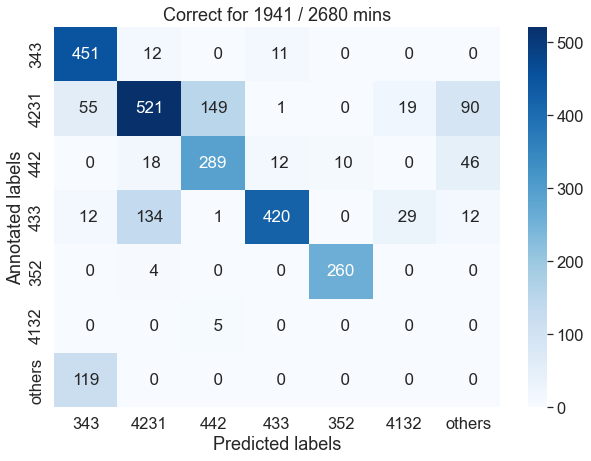

In [10]:
formations = ['343', '4231', '442', '433', '352', '4132', 'others']
conf_mat = confusion_matrix(
    mins_true['formation'].values, mins_pred['formation'].values, labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)
mins_common = pd.merge(mins_true, mins_pred)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='3d', annot_kws={"size": 17, })
plt.title(f"Correct for {len(mins_common)} / {len(mins_true)} mins")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
# plt.savefig('form_conf.pdf', bbox_inches='tight')

In [12]:
mins = pd.merge(mins_true, mins_pred, on=['activity_id', 'session', 'start_time'])
mins_discord = mins[mins['formation_x'] != mins['formation_y']]
mins_discord.groupby(['activity_id', 'session', 'formation_x', 'formation_y']).first().reset_index()

,activity_id,session,formation_x,formation_y,start_time
0,2310,1,4231,442,0
1,2310,2,4231,343,0
2,2310,2,433,343,42
3,5090,1,4231,others,39
4,5090,2,4231,others,0
5,5090,2,433,others,8
6,5420,1,4231,4132,0
7,5420,1,433,4132,19
8,5420,2,442,433,36
9,5458,1,others,343,0


#### (2) Role Change-Point Detection Accuracy

In [80]:
activity_ids = form_tags_true['activity_id'].unique()
cps_true = form_tags_true[form_tags_true['start_time'] != 0]
cps_pred = form_tags_pred[form_tags_pred['start_time'] != 0]
cps_pred

,activity_id,session,player_period,form_period,role_period,start_time,end_time,formation
2,43,2,3,2,3,12,32,442
3,43,2,4,2,4,32,39,442
4,43,2,5,2,5,39,49,442
6,56,1,1,1,2,27,46,433
8,56,2,3,2,4,9,39,4231
...,...,...,...,...,...,...,...,...
145,432,2,4,2,5,39,50,352
147,436,1,1,1,2,31,47,442
149,436,2,3,2,4,20,25,4231
150,436,2,4,2,5,25,43,4231


In [79]:
max_diff = 5

true_pos = 0
false_pos = 0
false_neg = 0

for activity_id in activity_ids:
    activity_cps_true = cps_true[cps_true['activity_id'] == activity_id]
    activity_cps_pred = cps_pred[cps_pred['activity_id'] == activity_id]
    
    for i in activity_cps_pred.index:
        for j in activity_cps_true.index:
            same_session = activity_cps_pred.at[i, 'session'] == activity_cps_true.at[j, 'session']
            time_diff = abs(activity_cps_pred.at[i, 'start_time'] - activity_cps_true.at[j, 'start_time'])
            
            found = False
            if same_session and time_diff <= max_diff:
                true_pos += 1
                found = True
                break
                
        if not found:
            false_pos += 1
            
    for i in activity_cps_true.index:
        for j in activity_cps_pred.index:
            same_session = activity_cps_true.at[i, 'session'] == activity_cps_pred.at[j, 'session']
            time_diff = abs(activity_cps_true.at[i, 'start_time'] - activity_cps_pred.at[j, 'start_time'])
            
            found = False
            if same_session and time_diff <= max_diff:
                found = True
                break
                
        if not found:
            false_neg += 1
                
true_pos, false_pos, false_neg

(86, 10, 7)

In [83]:
precision = round(true_pos / (true_pos + false_pos), 6)
recall = round(true_pos / (true_pos + false_neg), 6)
f1_score = round(2 * (precision * recall) / (precision + recall), 6)

precision, recall, f1_score

(0.895833, 0.924731, 0.910053)